## Import des packages

In [ ]:
#!pip install numpy pathlib pandas keras tensorflow scikit-learn pyarrow requests tqdm plotly matplotlib TKAN jax

   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 52.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/57.9 MB ? eta -:--:--
   --------------- ------------------------ 22.5/57.9 MB 109.8 MB/s eta 0:00:01
   ---------------------------- ----------- 41.9/57.9 MB 98.8 MB/s eta 0:00:01
   -------------------------------------- - 56.1/57.9 MB 89.3 MB/s eta 0:00:01
   ---------------------------------------- 57.9/57.9 MB 80.3 MB/s eta 0:00:00

   ---------------------------------------- 0/2 [jaxlib]
   ---------------------------------------- 0/2 [jaxlib]
   ---------------------------------------- 0/2 [jaxlib]
   ---------------------------------------- 0/2 [jaxlib]
   ---------------------------------------- 0/2 [jaxlib]
   ---------------------------------------- 0/2 [jaxlib]
   ---------------------------------------- 0/2 [jaxlib]
   ---------------------------------------- 0/2 [jaxlib]
   -------

In [ ]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Importation des modules nécessaires
import keras
from sklearn.preprocessing import MinMaxScaler

# Gestionnaire de données
from data.DataManager import DataManager

# Modèles de Deep Learning
from dl_models.MLPs import create_mlp_model,  LRHistory
from dl_models.CNNs import create_cnn_model
from dl_models.RNNs import GRU, LSTM, create_rnn_model_v2

# Métriques de performance / comparaison de modèles
from utils.visualization_tools import evaluate_and_plot
from utils.papers_runners import PaperEstimatorsRunner

In [2]:
keras.utils.set_random_seed(72)

# Nombre d'itération / taille de batch
N_MAX_EPOCH = 100
BATCH_SIZE = 32

# Liste de callbacks à utiliser dans les modèles
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.00001,
        patience = 10,
        mode = "min",
        restore_best_weights=True
    ),

    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_loss",
        factor = 0.25,
        patience = 5,
        min_delta = 0.00001,
        verbose = 0
    ),

    LRHistory()
]

# Import des données

In [3]:
# Définition des périodes de récupération
train_period: list = [(2023,7), (2023,8), (2023, 9), (2023,10)]
test_period: list = [(2023,11)]

# Choix lié à l'utilisation des indicateurs de dépendance sérielle
use_serial_dependance: bool = False

# Définition des actifs à récupérer
cryptos_train: list = ["ETHUSDT", "BNBUSDT", "XRPUSDT", "SOLUSDT", "ADAUSDT", "DOTUSDT"]
cryptos_test: list = ["MATICUSDT", "TRXUSDT"]

# Récupération du nombre d'actifs
nb_asset_train: int = len(cryptos_train)
nb_asset_test: int = len(cryptos_test)

# Création du datamanager pour gérer les données d'entrainement + import
manager_train: DataManager = DataManager(symbols=cryptos_train, dates=train_period, light=True)
manager_train.download_and_prepare_data()

# Construction des features / labels pour les données d'entrainement
feature_paths = manager_train.load_features(use_serial_dependance,use_tick_size=True)
labels_paths = manager_train.build_labels()

# Création du datamanager pour gérer les données de test (et import)
manager_test: DataManager = DataManager(symbols=cryptos_test, dates=test_period, light=True)
manager_test.download_and_prepare_data()

# Construction des features et labels pour les données de test
feature_paths_test = manager_test.load_features(use_serial_dependance,use_tick_size=True)
labels_paths_test = manager_test.build_labels()


# Test dataframe de construction de test et val
X_train, X_val, y_train, y_val = manager_train.build_train_val_dataset()

# Construction des tests
X_test, y_test = manager_test.build_train_val_dataset(is_test=True)

# Standardisation des features
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train).reshape(X_train.shape)
X_val_scaled = scaler_X.transform(X_val).reshape(X_val.shape)
X_test_scaled = scaler_X.transform(X_test).reshape(X_test.shape)

# Standardisation des labels (pour pas avoir des valeurs trop proches de 0)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

# Récupération des estimateurs papiers sur l'ensemble de test
runner = PaperEstimatorsRunner(
    symbols = cryptos_test,          
    periods = [(2023, 11)] * len(cryptos_test), 
    light_download = True)

df_est  = runner.get_estimates()
df_lab  = runner._load_labels_all()
df_all  = df_est.join(df_lab["spread_real"])
y_true  = df_all["spread_real"].values
paper_daily = df_all.drop(columns="spread_real")

# Métriques (toutes)
df_perf = runner.evaluate()


Klines déjà existant : c:\Users\timda\source\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-1m-2023-07.parquet
BookTicker déjà existant : c:\Users\timda\source\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-bookTicker-2023-07.parquet
Klines déjà existant : c:\Users\timda\source\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-1m-2023-08.parquet
BookTicker déjà existant : c:\Users\timda\source\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-bookTicker-2023-08.parquet
Klines déjà existant : c:\Users\timda\source\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-1m-2023-09.parquet
BookTicker déjà existant : c:\Users\timda\source\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-bookTicker-2023-09.parquet
Klines déjà existant : c:\Users\timda\source\Deep-Learning-for-Spread-Forecasting\data\raw data\ETHUSDT-1m-2023-10.parquet
BookTicker déjà existant : c:\Users\timda\source\Deep-Learning-for-Spread-Forecasting\data\raw data\ETH

## CNN

TRAIN CNN : (576, 1440, 16) (576, 1)
TRAIN CNN : (144, 1440, 16) (144, 1)
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 114.7285 - val_loss: 0.2321 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.3533 - val_loss: 0.2149 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.2209 - val_loss: 0.2138 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.2173 - val_loss: 0.2126 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2160 - val_loss: 0.2112 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.2146 - val_loss: 0.2098 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.2131 - val_loss: 0.2082 - learning_rate: 0.0010
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2114 - val_loss: 0.2065 - learning_rate: 0.0010
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36

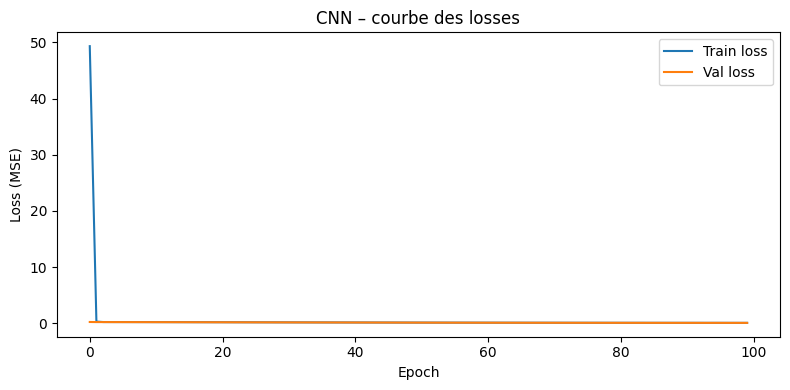

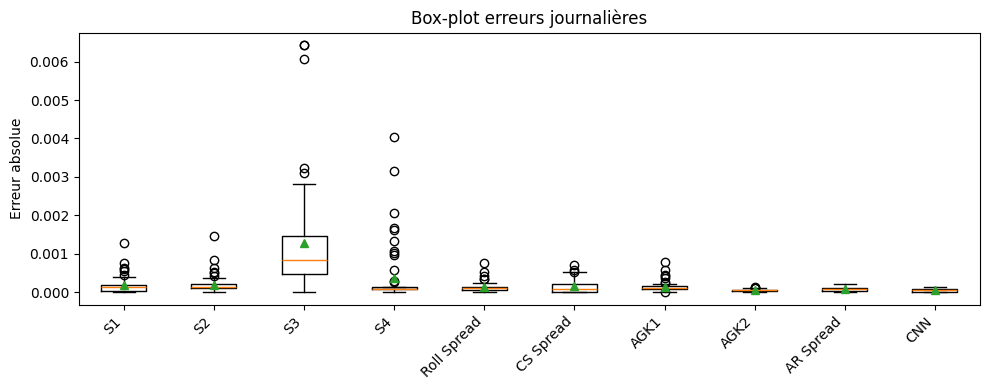

,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049769,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
CNN,NaN,0.000012,0.000009


,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049769,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
CNN,NaN,0.000012,0.000009


In [4]:
# Train CNN
X_tr_cnn, y_tr_cnn = manager_train.format_data(X_train_scaled, y_train_scaled,model_type='cnn',nb_assets=nb_asset_train,minutes_per_day=1440)
print("TRAIN CNN :", X_tr_cnn.shape, y_tr_cnn.shape)

#  Val CNN
X_val_cnn, y_val_cnn = manager_train.format_data(X_val_scaled, y_val_scaled,model_type='cnn',nb_assets=nb_asset_train,minutes_per_day=1440)
print("TRAIN CNN :", X_val_cnn.shape, y_val_cnn.shape)

# Création et entraînement du CNN
input_shape = X_tr_cnn.shape[1:]     # (1440, 16)
cnn = create_cnn_model(input_shape=input_shape, model_type="simple",output_activation='linear')

history = cnn.fit(X_tr_cnn, y_tr_cnn,validation_data=(X_val_cnn, y_val_cnn),epochs=N_MAX_EPOCH,batch_size=BATCH_SIZE,verbose=1,callbacks=callbacks)

# Formatage des features de test
X_te_cnn, y_te_cnn = manager_test.format_data(X_test_scaled,y_test_scaled,model_type='cnn',nb_assets=nb_asset_test,minutes_per_day=1440)
print("TEST CNN :", X_te_cnn.shape, y_te_cnn.shape)

# Résultat pour le CNN
evaluate_and_plot(model = cnn,X = X_te_cnn,y = y_te_cnn,manager = manager_test,scaler_y=scaler_y,title = "CNN",
                  history = history,paper_daily = paper_daily,paper_metrics = df_perf,y_true_daily = y_true)  



## MLP

TRAIN MLP : (576, 23040) (576, 1)
VAL MLP : (144, 23040) (144, 1)
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.4315 - val_loss: 0.1944 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1136 - val_loss: 0.0752 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0809 - val_loss: 0.0601 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0578 - val_loss: 0.0532 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0549 - val_loss: 0.1271 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0792 - val_loss: 0.0935 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0672 - val_loss: 0.0378 - learning_rate: 0.0010
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0409 - val_loss: 0.0541 - learning_rate: 0.0010
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - 

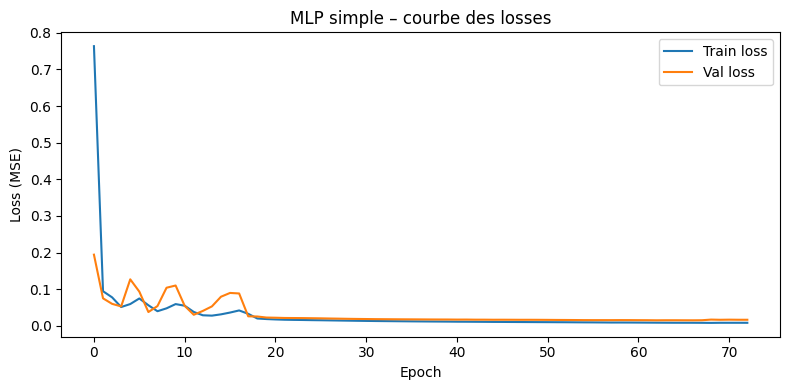

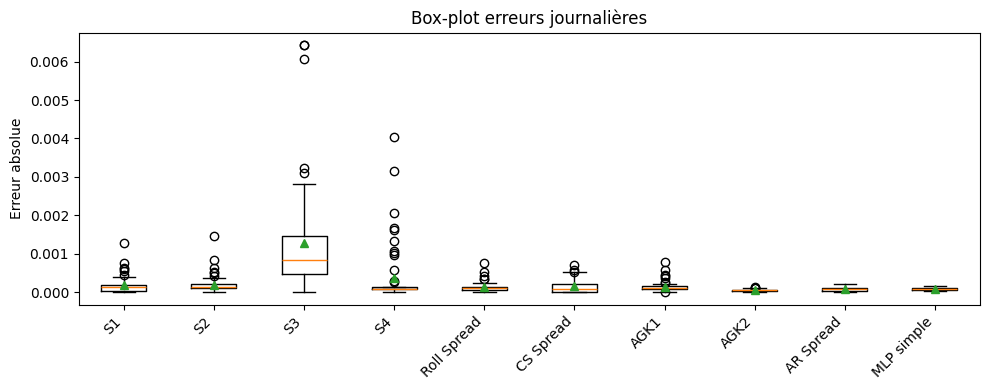

,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049769,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
MLP simple,NaN,0.000101,0.000080


,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049769,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
MLP simple,NaN,0.000101,0.000080


In [5]:
# Mise en forme des données pour le MLP
X_tr_mlp, y_tr_mlp = manager_train.format_data(X_train_scaled, y_train_scaled,model_type='mlp',nb_assets=nb_asset_train,minutes_per_day=1440)    
print("TRAIN MLP :", X_tr_mlp.shape, y_tr_mlp.shape)

#  Val CNN
X_val_mlp, y_val_mlp = manager_train.format_data(X_val_scaled, y_val_scaled,model_type='mlp',nb_assets=nb_asset_train,minutes_per_day=1440)
print("VAL MLP :", X_val_mlp.shape, y_val_mlp.shape)


# Construction et entraînement du modèle MLP
input_shape = X_tr_mlp.shape
mlp = create_mlp_model(input_shape=input_shape,model_type="simple",hidden_dims=[128, 64, 32],output_activation  = "linear")
    

history_mlp = mlp.fit(X_tr_mlp, y_tr_mlp,validation_data = (X_val_mlp, y_val_mlp),epochs=N_MAX_EPOCH,batch_size=BATCH_SIZE,verbose=1,callbacks=callbacks)

#Préparation du set de test au même format
X_te_mlp, y_te_mlp = manager_test.format_data(X_test_scaled, y_test_scaled,model_type='mlp',nb_assets=nb_asset_test,minutes_per_day=1440)
print("TEST  MLP :", X_te_mlp.shape, y_te_mlp.shape)

# Graphique et comparaison avec les estimateurs de Garcin
evaluate_and_plot(model = mlp,X = X_te_mlp,y = y_te_mlp,manager = manager_test,title = "MLP simple",
                  scaler_y= scaler_y,history = history_mlp,paper_daily = paper_daily,paper_metrics = df_perf,y_true_daily = y_true,)      

# LSTM

TRAIN LSTM : (576, 1440, 16) (576, 1)
VAL LSTM : (144, 1440, 16) (144, 1)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1440, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        47,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,101 (183.99 KB)

 Trainable params: 47,101 (183.99 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1603s 29s/step - loss: 0.1450 - mae: 0.3295 - val_loss: 0.1059 - val_mae: 0.2900 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 181s 10s/step - loss: 0.1076 - mae: 0.2857 - val_loss: 0.0874 - val_mae: 0.2598 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 181s 10s/step - loss: 0.0877 - mae: 0.2600 - val_loss: 0.0802 - val_mae: 0.2466 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 180s 10s/step - loss: 0.0763 - mae: 0.2367 - val_loss: 0.0701 - val_mae: 0.2215 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 181s 10s/step - loss: 0.0678 - mae: 0.2171 - val_loss: 0.0609 - val_mae: 0.2007 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 182s 10s/step - loss: 0.0652 - mae: 0.2116 - val_loss: 0.0605 - val_mae: 0.1933 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 180s 10s/step - loss: 0.0659 - mae: 0.2082 - val_loss: 0.0585 - val_mae: 0.1884 - learning_rate: 0.001

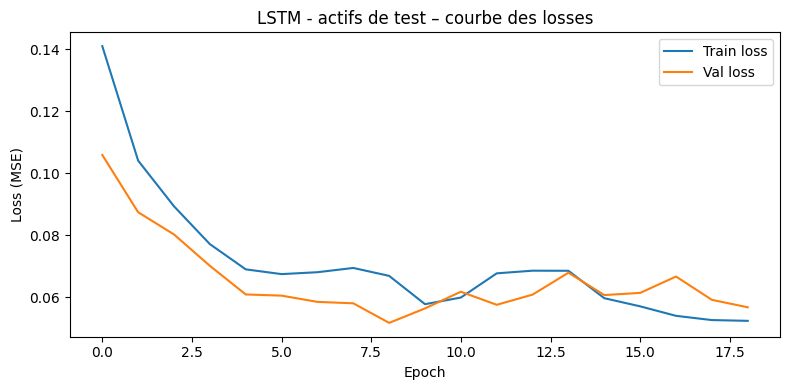

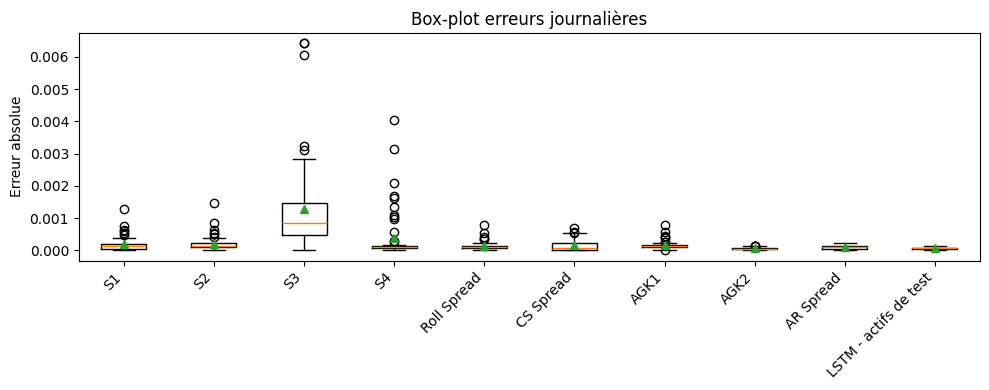

,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049769,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
LSTM - actifs de test,NaN,0.000044,0.000035


In [ ]:
X_tr_lstm, y_tr_lstm = manager_train.format_data(X_train_scaled, y_train_scaled,model_type='rnn',nb_assets=nb_asset_train,minutes_per_day=1440) 
print("TRAIN LSTM :", X_tr_lstm.shape, y_tr_lstm.shape)

X_val_lstm, y_val_lstm = manager_train.format_data(X_val_scaled, y_val_scaled,model_type = 'rnn',nb_assets = nb_asset_train,minutes_per_day = 1440)
print("VAL LSTM :", X_val_lstm.shape, y_val_lstm.shape)


input_shape = X_tr_lstm.shape[1:]  
lstm_model = create_rnn_model_v2(input_shape = input_shape,nb_assets = 1,rnn_layer = LSTM(units=100, return_sequences=False, dropout=0.3),use_simple_model = True)
history_lstm = lstm_model.fit(X_tr_lstm, y_tr_lstm,validation_data = (X_val_lstm, y_val_lstm),epochs = N_MAX_EPOCH,batch_size = BATCH_SIZE,verbose = 1,callbacks = callbacks)  
    
X_te_lstm, y_te_lstm = manager_test.format_data(X_test_scaled, y_test_scaled,model_type='rnn',nb_assets=1,minutes_per_day=1440)
print("TEST LSTM :", X_te_lstm.shape, y_te_lstm.shape)

df_compare_lstm = evaluate_and_plot(model = lstm_model,X = X_te_lstm,y = y_te_lstm,manager = manager_test,scaler_y = scaler_y,
                                   title = "LSTM - actifs de test",history = history_lstm,paper_metrics = df_perf,paper_daily = paper_daily,y_true_daily = y_true)    
    

## RNN GRU

TRAIN GRU : (576, 1440, 16) (576, 1)
VAL GRU : (144, 1440, 16) (144, 1)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1440, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100)            │        35,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,401 (138.29 KB)

 Trainable params: 35,401 (138.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1268s 20s/step - loss: 0.4373 - mae: 0.5492 - val_loss: 0.1929 - val_mae: 0.3906 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - loss: 0.1090 - mae: 0.2838 - val_loss: 0.0766 - val_mae: 0.2369 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - loss: 0.0755 - mae: 0.2312 - val_loss: 0.0701 - val_mae: 0.2151 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - loss: 0.0663 - mae: 0.2056 - val_loss: 0.0630 - val_mae: 0.1878 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - loss: 0.0612 - mae: 0.1927 - val_loss: 0.0629 - val_mae: 0.1875 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - loss: 0.0606 - mae: 0.1840 - val_loss: 0.0622 - val_mae: 0.1827 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - loss: 0.0515 - mae: 0.1726 - val_loss: 0.0560 - val_mae: 0.1603 - learning_rate: 0.0010
Epoch 8/10

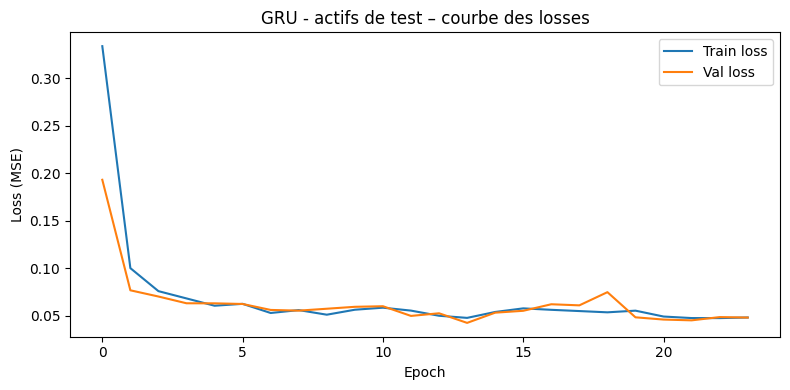

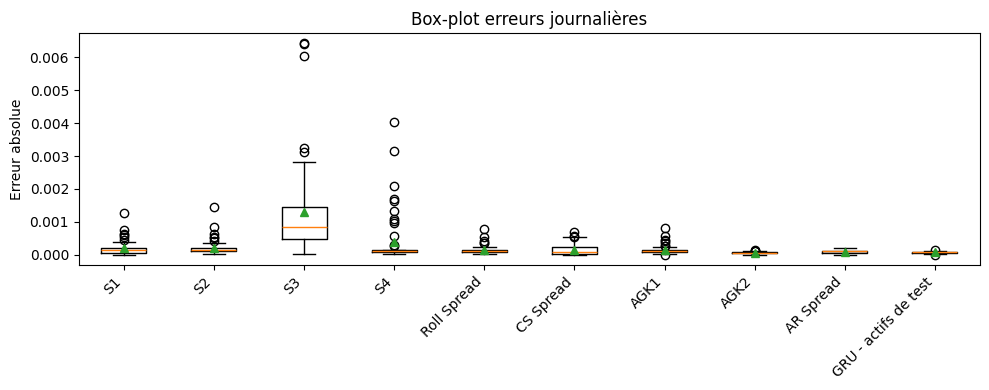

,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049769,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
GRU - actifs de test,NaN,0.000061,0.000049


In [5]:
X_tr_gru, y_tr_gru = manager_train.format_data(X_train_scaled, y_train_scaled,model_type='rnn',nb_assets=nb_asset_train,minutes_per_day=1440) 
print("TRAIN GRU :", X_tr_gru.shape, y_tr_gru.shape)

X_val_gru, y_val_gru = manager_train.format_data(X_val_scaled, y_val_scaled,model_type = 'rnn',nb_assets = nb_asset_train,minutes_per_day = 1440)
print("VAL GRU :", X_val_gru.shape, y_val_gru.shape)


input_shape = X_tr_gru.shape[1:]
gru_model = create_rnn_model_v2(input_shape = input_shape,nb_assets = 1,rnn_layer = GRU(units=100, return_sequences=False, dropout=0.3),use_simple_model = True)    
history_gru = gru_model.fit(X_tr_gru, y_tr_gru,validation_data = (X_val_gru, y_val_gru),epochs = N_MAX_EPOCH,batch_size = BATCH_SIZE,verbose = 1,callbacks = callbacks)  
    
X_te_gru, y_te_gru = manager_test.format_data(X_test_scaled, y_test_scaled,model_type='rnn',nb_assets=1,minutes_per_day=1440)
print("TEST GRU :", X_te_gru.shape, y_te_gru.shape)

df_compare_gru = evaluate_and_plot(model = gru_model,X = X_te_gru,y = y_te_gru,manager = manager_test,scaler_y = scaler_y,
                                   title = "GRU - actifs de test",history = history_gru,paper_metrics = df_perf,paper_daily = paper_daily,y_true_daily = y_true)    
    

# TKAN

TRAIN TKAN : (576, 1440, 16) (576, 1)
VAL   TKAN : (144, 1440, 16) (144, 1)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1440, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tkan_2 (TKAN)                   │ (None, 100)            │        41,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,121 (160.63 KB)

 Trainable params: 40,921 (159.85 KB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 106s 6s/step - loss: 0.0943 - mae: 0.2693 - val_loss: 0.0842 - val_mae: 0.2434 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 103s 6s/step - loss: 0.0793 - mae: 0.2365 - val_loss: 0.0697 - val_mae: 0.2181 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 111s 6s/step - loss: 0.0702 - mae: 0.2165 - val_loss: 0.0616 - val_mae: 0.1994 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - loss: 0.0620 - mae: 0.1959 - val_loss: 0.0572 - val_mae: 0.1859 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - loss: 0.0573 - mae: 0.1806 - val_loss: 0.0547 - val_mae: 0.1756 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 107s 6s/step - loss: 0.0563 - mae: 0.1728 - val_loss: 0.0519 - val_mae: 0.1691 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 106s 6s/step - loss: 0.0543 - mae: 0.1665 - val_loss: 0.0499 - val_mae: 0.1640 - learning_rate: 0.0010
Epoch 

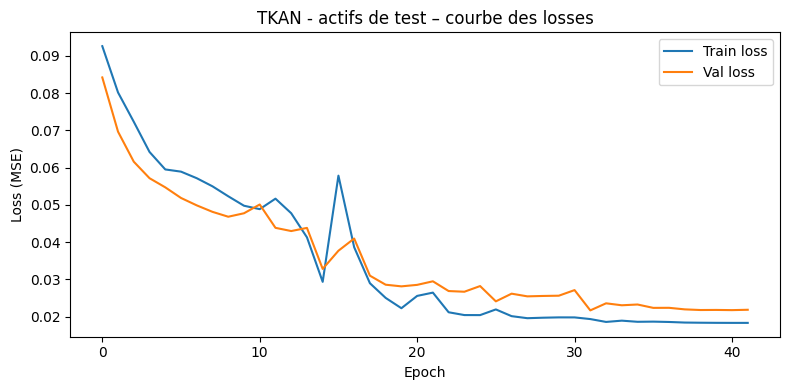

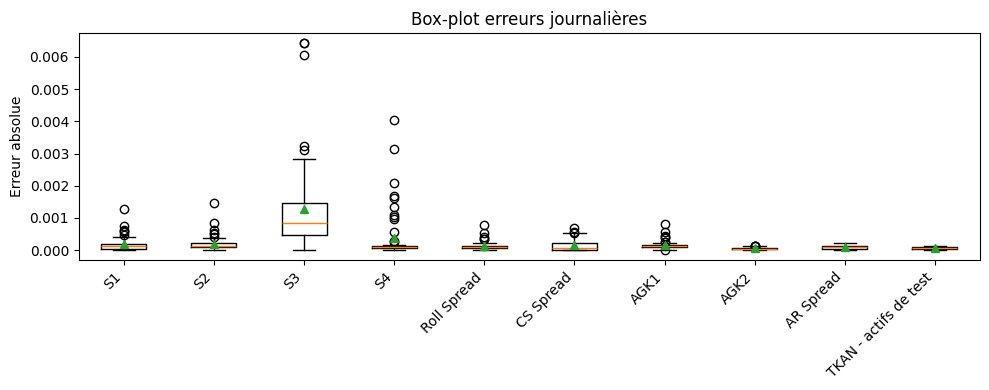

,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049769,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
TKAN - actifs de test,NaN,0.000059,0.000046


In [7]:
import os
os.environ["KERAS_BACKEND"] = "jax"
from tkan import TKAN


X_tr_tkan, y_tr_tkan = manager_train.format_data(X_train_scaled, y_train_scaled,model_type='rnn',nb_assets=nb_asset_train,minutes_per_day=1440)
print("TRAIN TKAN :", X_tr_tkan.shape, y_tr_tkan.shape)

X_val_tkan, y_val_tkan = manager_train.format_data(X_val_scaled, y_val_scaled,model_type='rnn',nb_assets=nb_asset_train,minutes_per_day=1440)  
print("VAL   TKAN :", X_val_tkan.shape, y_val_tkan.shape)


input_shape = X_tr_tkan.shape[1:]   
tkan_model = create_rnn_model_v2(input_shape = input_shape,nb_assets = 1,rnn_layer = TKAN(100, sub_kan_output_dim=20, sub_kan_input_dim=20, return_sequences=False) ,use_simple_model = True)
history_tkan = tkan_model.fit(X_tr_tkan, y_tr_tkan,validation_data = (X_val_tkan, y_val_tkan),epochs = N_MAX_EPOCH,batch_size = BATCH_SIZE,verbose = 1,callbacks = callbacks)
    

X_te_tkan, y_te_tkan = manager_test.format_data(X_test_scaled, y_test_scaled,model_type='rnn',nb_assets=nb_asset_test,minutes_per_day=1440)
print("TEST TKAN :", X_te_tkan.shape, y_te_tkan.shape)

df_compare_tkan = evaluate_and_plot(model = tkan_model,X = X_te_tkan,y = y_te_tkan,manager = manager_test,scaler_y = scaler_y,title = "TKAN - actifs de test",
                                    history = history_tkan,paper_metrics = df_perf,paper_daily = paper_daily,y_true_daily   = y_true)      

# GRU custom

TRAIN GRU : (576, 1440, 16) (576, 1)
VAL GRU : (144, 1440, 16) (144, 1)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1440, 16)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1440, 32)  │      1,568 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 1440, 100) │     40,100 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1440, 100) │    161,300 │ gru[0][0],        │
│ (MultiHeadAttentio… │                   │            │ gru[0][0],        │
│                     │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 144000)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │    144,001 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 346,969 (1.32 MB)

 Trainable params: 346,969 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1492s 29s/step - loss: 0.2358 - mae: 0.3828 - val_loss: 0.2142 - val_mae: 0.3440 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 226s 11s/step - loss: 0.2180 - mae: 0.3496 - val_loss: 0.2142 - val_mae: 0.3440 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 185s 10s/step - loss: 0.2180 - mae: 0.3496 - val_loss: 0.2142 - val_mae: 0.3440 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 185s 10s/step - loss: 0.2180 - mae: 0.3496 - val_loss: 0.2142 - val_mae: 0.3440 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 180s 10s/step - loss: 0.2180 - mae: 0.3496 - val_loss: 0.2142 - val_mae: 0.3440 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 179s 10s/step - loss: 0.2180 - mae: 0.3496 - val_loss: 0.2142 - val_mae: 0.3440 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 180s 10s/step - loss: 0.2180 - mae: 0.3496 - val_loss: 0.2142 - val_mae: 0.3440 - learning_rate: 2.500

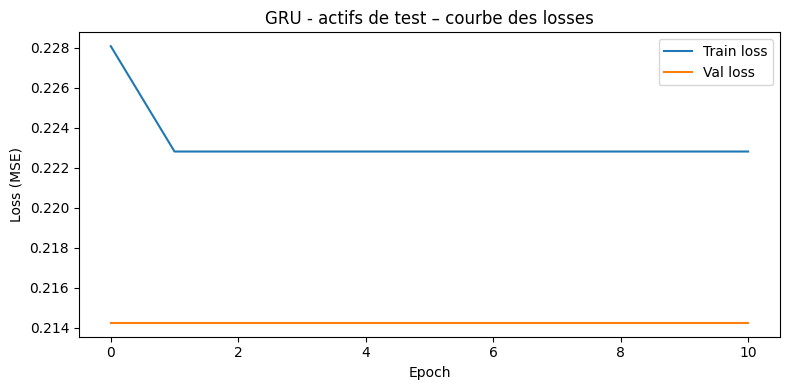

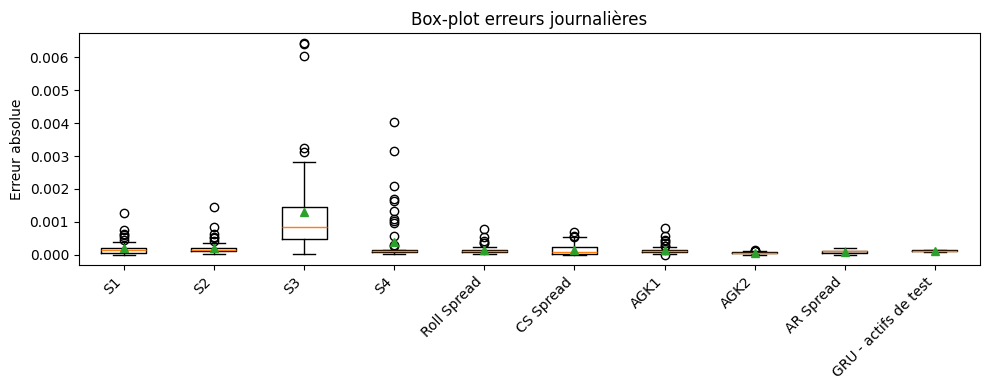

,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049769,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
GRU - actifs de test,NaN,0.000071,0.000055


In [ ]:
X_tr_gru, y_tr_gru = manager_train.format_data(X_train_scaled, y_train_scaled,model_type='rnn',nb_assets=nb_asset_train,minutes_per_day=1440) 
print("TRAIN GRU :", X_tr_gru.shape, y_tr_gru.shape)

X_val_gru, y_val_gru = manager_train.format_data(X_val_scaled, y_val_scaled,model_type = 'rnn',nb_assets = nb_asset_train,minutes_per_day = 1440)
print("VAL GRU :", X_val_gru.shape, y_val_gru.shape)


input_shape = X_tr_gru.shape[1:]
gru_model = create_rnn_model_v2(input_shape = input_shape,nb_assets = 1,rnn_layer = GRU(units=100, return_sequences=True, dropout=0.3),use_simple_model = False)    
history_gru = gru_model.fit(X_tr_gru, y_tr_gru,validation_data = (X_val_gru, y_val_gru),epochs = N_MAX_EPOCH,batch_size = BATCH_SIZE,verbose = 1,callbacks = callbacks)  
    
X_te_gru, y_te_gru = manager_test.format_data(X_test_scaled, y_test_scaled,model_type='rnn',nb_assets=1,minutes_per_day=1440)
print("TEST GRU :", X_te_gru.shape, y_te_gru.shape)

df_compare_gru = evaluate_and_plot(model = gru_model,X = X_te_gru,y = y_te_gru,manager = manager_test,scaler_y = scaler_y,
                                   title = "GRU - actifs de test",history = history_gru,paper_metrics = df_perf,paper_daily = paper_daily,y_true_daily = y_true)    
    

# LSTM custom

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1440, 16)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1440, 32)  │      1,568 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 1440, 100) │     53,400 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1440, 100) │    161,300 │ lstm[0][0],       │
│ (MultiHeadAttentio… │                   │            │ lstm[0][0],       │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 144000)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │    144,001 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 360,269 (1.37 MB)

 Trainable params: 360,269 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1965s 36s/step - loss: 0.4662 - mae: 0.4872 - val_loss: 0.1273 - val_mae: 0.2488 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 294s 16s/step - loss: 0.0874 - mae: 0.2177 - val_loss: 0.1168 - val_mae: 0.2376 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 289s 16s/step - loss: 0.0688 - mae: 0.1996 - val_loss: 0.1112 - val_mae: 0.2327 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 285s 16s/step - loss: 0.0703 - mae: 0.1943 - val_loss: 0.0956 - val_mae: 0.2253 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 281s 16s/step - loss: 0.0810 - mae: 0.2096 - val_loss: 0.0926 - val_mae: 0.2178 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 282s 16s/step - loss: 0.0769 - mae: 0.2064 - val_loss: 0.1149 - val_mae: 0.2335 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 292s 16s/step - loss: 0.0693 - mae: 0.1910 - val_loss: 0.1341 - val_mae: 0.2482 - learning_rate: 0.001

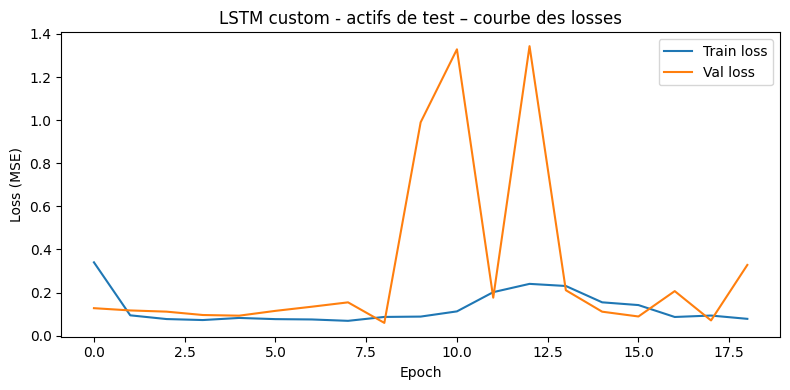

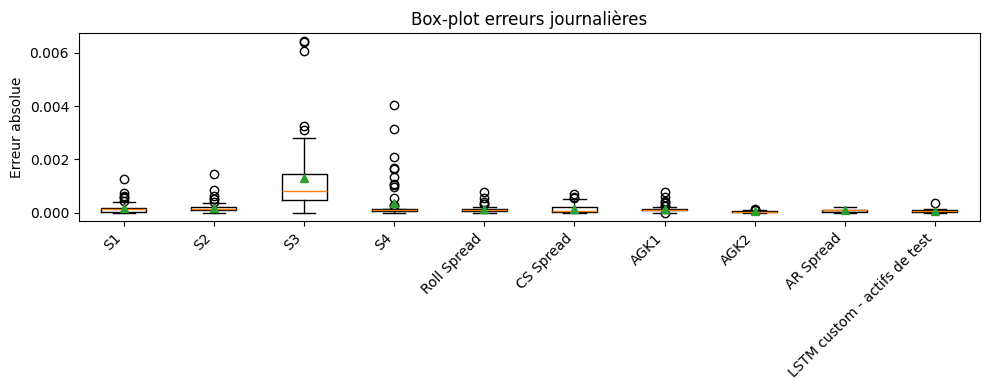

,R²,RMSE,MAE
S1,-222.608059,0.000284,0.000187
S2,-245.777907,0.000298,0.000199
S3,-9972.306909,0.001895,0.001291
S4,-1935.049769,0.000835,0.000375
Roll Spread,-93.595646,0.000185,0.000136
CS Spread,-147.796496,0.000231,0.000154
AGK1,-109.575991,0.000200,0.000150
AGK2,-10.938703,0.000066,0.000058
AR Spread,-27.382045,0.000101,0.000089
LSTM custom - actifs de test,NaN,0.000056,0.000025


In [4]:
X_tr_lstm, y_tr_lstm = manager_train.format_data(X_train_scaled, y_train_scaled,model_type='rnn',nb_assets=nb_asset_train,minutes_per_day=1440) 
X_val_lstm, y_val_lstm = manager_train.format_data(X_val_scaled, y_val_scaled,model_type = 'rnn',nb_assets = nb_asset_train,minutes_per_day = 1440)


input_shape = X_tr_lstm.shape[1:]
lstm_custom_model = create_rnn_model_v2(input_shape = input_shape,nb_assets = 1,rnn_layer = LSTM(units=100, return_sequences=True, dropout=0.3),use_simple_model = False)    
history_lstm_custom = lstm_custom_model.fit(X_tr_lstm, y_tr_lstm,validation_data = (X_val_lstm, y_val_lstm),epochs = N_MAX_EPOCH,batch_size = BATCH_SIZE,verbose = 1,callbacks = callbacks)  
    
X_te_lstm, y_te_lstm = manager_test.format_data(X_test_scaled, y_test_scaled,model_type='rnn',nb_assets=1,minutes_per_day=1440)
df_compare_lstm_custom = evaluate_and_plot(model = lstm_custom_model,X = X_te_lstm,y = y_te_lstm,manager = manager_test,scaler_y = scaler_y,
                                   title = "LSTM custom - actifs de test",history = history_lstm_custom,paper_metrics = df_perf,paper_daily = paper_daily,y_true_daily = y_true)    
    